In [224]:
import pandas as pd
import tensorflow as tf
import keras as ks
import numpy as np
import seaborn as sns
from keras.layers import Dense, Dropout, Conv2D, Flatten, Activation
from keras.models import Sequential

from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pylab as plt

In [225]:
dataset = pd.read_csv('../../data/cleaned/site1_malin.csv')
dataset.head()

,date (mm.dd.yyyy),Depth [m],T [deg C],DO [%],SPC [micro S/cm],NH4 [mg/l],NO3 [mg/l],PO4 [mg/l],Chl tot [micro g/l],Chl cyano [micro g/l],Chl green Al. [micro g/l],turb [FTU],Secci Depth [m],pH
0,6/1/2016,0.0,20.8,127.3,748,0.877326755,0.162558848,0.012251796,39.8,3.2,36.6,5.1,0.8,8.63
1,6/1/2016,0.5,20.8,127.0,748,-,-,-,55.4,3.7,51.7,4.8,-,8.65
2,6/1/2016,1.0,20.4,131.4,756,-,-,-,45.6,3.0,42.6,4.9,-,8.66
3,6/1/2016,2.0,18.0,85.4,775,-,-,-,41.0,3.9,37.1,5.0,-,8.25
4,6/1/2016,3.0,15.8,4.0,786,1.050011213,0.270562171,0.031263202,54.6,5.8,48.8,5.8,-,7.89


In [226]:
df = dataset.drop(columns=['NH4 [mg/l]', 'NO3 [mg/l]', 'PO4 [mg/l]', 'Secci Depth [m]'])
df.head()

,date (mm.dd.yyyy),Depth [m],T [deg C],DO [%],SPC [micro S/cm],Chl tot [micro g/l],Chl cyano [micro g/l],Chl green Al. [micro g/l],turb [FTU],pH
0,6/1/2016,0.0,20.8,127.3,748,39.8,3.2,36.6,5.1,8.63
1,6/1/2016,0.5,20.8,127.0,748,55.4,3.7,51.7,4.8,8.65
2,6/1/2016,1.0,20.4,131.4,756,45.6,3.0,42.6,4.9,8.66
3,6/1/2016,2.0,18.0,85.4,775,41.0,3.9,37.1,5.0,8.25
4,6/1/2016,3.0,15.8,4.0,786,54.6,5.8,48.8,5.8,7.89


In [227]:
df.dtypes

date (mm.dd.yyyy)             object
Depth [m]                    float64
T [deg C]                    float64
DO [%]                       float64
SPC [micro S/cm]               int64
Chl tot [micro g/l]          float64
Chl cyano [micro g/l]        float64
Chl green Al. [micro g/l]    float64
turb [FTU]                   float64
pH                           float64
dtype: object

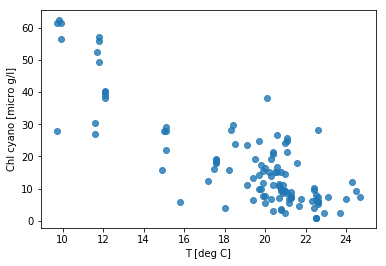

In [228]:
sns.regplot(x=df['T [deg C]'], y=df['Chl cyano [micro g/l]'], fit_reg=False)

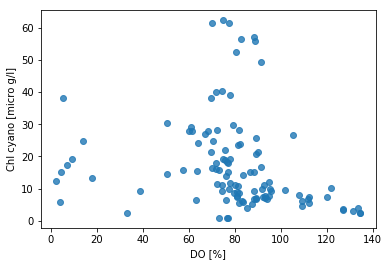

In [229]:
sns.regplot(x=df['DO [%]'], y=df['Chl cyano [micro g/l]'], fit_reg=False)

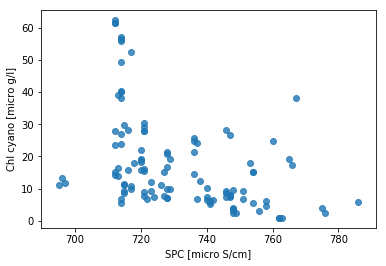

In [230]:
sns.regplot(x=df['SPC [micro S/cm]'], y=df['Chl cyano [micro g/l]'], fit_reg=False)

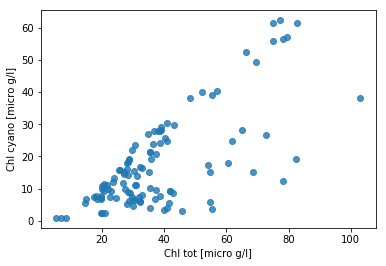

In [231]:
sns.regplot(x=df['Chl tot [micro g/l]'], y=df['Chl cyano [micro g/l]'], fit_reg=False)

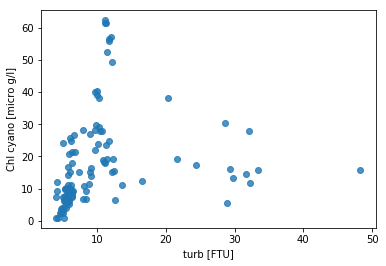

In [232]:
sns.regplot(x=df['turb [FTU]'], y=df['Chl cyano [micro g/l]'], fit_reg=False)

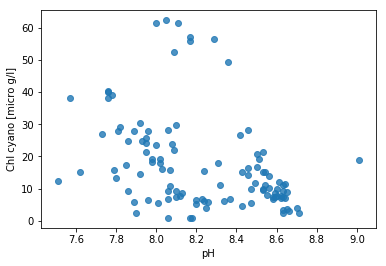

In [233]:
sns.regplot(x=df['pH'], y=df['Chl cyano [micro g/l]'], fit_reg=False)

In [234]:
df_train, df_test = train_test_split(df)
print(df.shape[0], df_train.shape[0], df_test.shape[0])

110 82 28


In [235]:
y_train = df_train['Chl cyano [micro g/l]'].values
y_test = df_test['Chl cyano [micro g/l]'].values

In [236]:
columns = ['Depth [m]', 'T [deg C]', 'DO [%]',
       'SPC [micro S/cm]', 'Chl tot [micro g/l]',
       'Chl green Al. [micro g/l]', 'turb [FTU]', 'pH']

### Null Model

In [237]:
zeros_train = np.zeros(df_train.shape)
zeros_test = np.zeros(df_test.shape)
null_model = SGDRegressor(max_iter=3000)
null_model.fit(zeros_train, y_train)
predict_chl_test = null_model.predict(zeros_test)
null_mse = mean_squared_error(y_test, predict_chl_test)
null_rmse = np.sqrt(null_mse)

print("Null Model MSE:", null_mse)
print("Null Model RMSE:", null_rmse)

Null Model MSE: 154.263443605
Null Model RMSE: 12.4202835557


In [238]:
for column in columns:
    x_train = df_train[[column]].values
    x_test = df_test[[column]].values
    
#     Use an imputer to replace any null values with 0 so that they are still counted
    imputer = Imputer(missing_values=0)
    x_train_imputed = imputer.fit_transform(x_train)
    x_test_imputed = imputer.transform(x_test)
    
#     Use a scaler to normalize the data
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train_imputed)
    x_test_scaled = scaler.transform(x_test_imputed)
    
    lr = SGDRegressor(max_iter=5000)
    lr.fit(x_train_scaled.reshape(-1, 1), y_train)
    predict_chl_test = lr.predict(x_test_scaled.reshape(-1, 1))
    lr_mse = mean_squared_error(y_test, predict_chl_test)
    lr_rmse = np.sqrt(lr_mse)
    
    print()
    print(column + " Model MSE:", lr_mse)
    print(column + " Model RMSE:", lr_rmse)

/home/naomi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/naomi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)



Depth [m] Model MSE: 155.614848318
Depth [m] Model RMSE: 12.4745680614

T [deg C] Model MSE: 81.5284517966
T [deg C] Model RMSE: 9.0293107044

DO [%] Model MSE: 139.835937815
DO [%] Model RMSE: 11.8252246412


/home/naomi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/naomi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)



SPC [micro S/cm] Model MSE: 138.347405088
SPC [micro S/cm] Model RMSE: 11.7621173727

Chl tot [micro g/l] Model MSE: 64.2399054772
Chl tot [micro g/l] Model RMSE: 8.01498006718


/home/naomi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/naomi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)



Chl green Al. [micro g/l] Model MSE: 156.033562969
Chl green Al. [micro g/l] Model RMSE: 12.4913395186


/home/naomi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)



turb [FTU] Model MSE: 145.371053168
turb [FTU] Model RMSE: 12.0569918789


/home/naomi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)



pH Model MSE: 102.616801604
pH Model RMSE: 10.1299951433


In [239]:
sorted_columns = ['T [deg C]', 'pH', 'SPC [micro S/cm]', 'DO [%]', 'turb [FTU]', 'Depth [m]']
all_sorted_columns = ['T [deg C]', 'pH', 'Chl tot [micro g/l]', 'SPC [micro S/cm]', 'DO [%]', 'turb [FTU]', 'Depth [m]', 'Chl green Al. [micro g/l]']

In [240]:
base_model_columns = []
base_model = null_model
base_rmse = null_rmse
base_mse = null_mse

print("Null Model MSE:", null_mse)
print("Null Model RMSE:", null_rmse)

for column in sorted_columns:
    print("Base Model MSE:", base_mse)
    print("Base Model RMSE:", base_rmse)
    print()
    
    trial_columns = base_model_columns[:]
    trial_columns.append(column)
    
    x_train = df_train[trial_columns].values
    x_test = df_test[trial_columns].values
    
    imputer = Imputer(missing_values=0)
    x_train_imputed = imputer.fit_transform(x_train)
    x_test_imputed = imputer.transform(x_test)
    
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train_imputed)
    x_test_scaled = scaler.transform(x_test_imputed)
    
    trial_lr = SGDRegressor(max_iter=5000)
    trial_lr.fit(x_train_scaled, y_train)
    predict_chl_test = trial_lr.predict(x_test_scaled)
    trial_mse = mean_squared_error(y_test, predict_chl_test)
    trial_rmse = np.sqrt(trial_mse)
    
    print()
    print(str(trial_columns) + " Model MSE:", trial_mse)
    print(str(trial_columns) + " Model RMSE:", trial_rmse)
    
    if trial_rmse < base_rmse:
        print("Updating base model")
        base_rmse = trial_rmse
        base_mse = trial_mse
        base_model = trial_lr
        base_model_columns = trial_columns
    print()

Null Model MSE: 154.263443605
Null Model RMSE: 12.4202835557
Base Model MSE: 154.263443605
Base Model RMSE: 12.4202835557



/home/naomi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)



['T [deg C]'] Model MSE: 81.5825005557
['T [deg C]'] Model RMSE: 9.03230317005
Updating base model

Base Model MSE: 81.5825005557
Base Model RMSE: 9.03230317005



/home/naomi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)



['T [deg C]', 'pH'] Model MSE: 81.4309277112
['T [deg C]', 'pH'] Model RMSE: 9.02390867148
Updating base model

Base Model MSE: 81.4309277112
Base Model RMSE: 9.02390867148



/home/naomi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)



['T [deg C]', 'pH', 'SPC [micro S/cm]'] Model MSE: 82.705498789
['T [deg C]', 'pH', 'SPC [micro S/cm]'] Model RMSE: 9.09425636262

Base Model MSE: 81.4309277112
Base Model RMSE: 9.02390867148



/home/naomi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)



['T [deg C]', 'pH', 'DO [%]'] Model MSE: 81.3942660009
['T [deg C]', 'pH', 'DO [%]'] Model RMSE: 9.02187707747
Updating base model

Base Model MSE: 81.3942660009
Base Model RMSE: 9.02187707747



/home/naomi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)



['T [deg C]', 'pH', 'DO [%]', 'turb [FTU]'] Model MSE: 85.6229901945
['T [deg C]', 'pH', 'DO [%]', 'turb [FTU]'] Model RMSE: 9.25326916255

Base Model MSE: 81.3942660009
Base Model RMSE: 9.02187707747


['T [deg C]', 'pH', 'DO [%]', 'Depth [m]'] Model MSE: 74.2937751076
['T [deg C]', 'pH', 'DO [%]', 'Depth [m]'] Model RMSE: 8.61938368491
Updating base model



/home/naomi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


(0, 48.236553278731236)

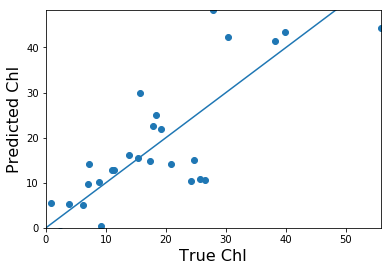

In [241]:
plt.scatter(y_test, predict_chl_test)
maximum = max(max(y_test), max(predict_chl_test))
plt.plot([0, maximum], [0, maximum])
plt.xlabel("True Chl", fontsize=16)
plt.ylabel("Predicted Chl", fontsize=16)
plt.xlim([0, max(y_test)])
plt.ylim([0, max(predict_chl_test)])